# HW Guide Part A: Replicate Fama-French 1993

**Summary**

The Fama and French (1993) paper, "Common Risk Factors in the Returns on Stocks and Bonds," revolutionized asset pricing theory by challenging the Capital Asset Pricing Model (CAPM) with a three-factor model that includes market risk, size (market capitalization), and book-to-market value as predictors of stock returns. They demonstrated that the market factor alone does not fully explain stock returns and that small stocks and stocks with high book-to-market ratios yield higher returns than can be explained
by market beta alone, suggesting that these factors capture additional risks not accounted for by the CAPM. This seminal work has significantly influenced academic research and investment practices by highlighting the importance of size and value factors in asset pricing, thereby laying the groundwork for more sophisticated models and strategies in finance.

**Learning Outcomes**

1. **Work with CRSP and Compustat datasets**: Gain hands-on experience in using financial data sources that provide stock market prices and firm-level accounting data, which are essential for empirical research in finance.

2. **Leverage the CRSP/Compustat Merged (CCM) database**: Understand the purpose and structure of the CCM linking table, and use it to accurately merge CRSP’s market data with Compustat’s fundamental data.

3. **Construct Fama-French portfolios and factors**: Use market capitalization and book-to-market ratios to classify firms into portfolios, calculate value-weighted returns, and compute the size (SMB) and value (HML) factors.

4. **Compare your results with established benchmarks**: Validate your manually computed Fama-French factors against the official data from Kenneth French’s library and analyze any differences.


**Game Plan**

The code underlying this notebook follows the methodology described in https://wrds-www.wharton.upenn.edu/pages/wrds-research/applications/risk-factors-and-industry-benchmarks/fama-french-factors/ . I will quote from that methodology extensively. There is also a set
of videos on this linked website. Those may be helpful for this exercise.

The code is lightly edited from the code provided by WRDS on their website.



In [1]:
import datetime

import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

import calc_Fama_French_1993
import pull_CRSP_Compustat
import pull_CRSP_stock
import shared_portfolio_sorts
from settings import config

DATA_DIR = config("DATA_DIR")

## Prep Data

### Step 1. Load Data

In order to replicate the factors from this paper, we need data from CRSP and Compustat. The CRSP data provides the stock prices while Compustat provides the fundamentals. We also use the CRSP/Compustat Linking Table to merge the two datasets. The merge is not straightforward, but there is a standard procedure used that is embodied in the linking table provided by CRSP and available on WRDS.

 - The **CRSP dataset** contains stock market data, including prices, returns, and shares outstanding, for securities traded on major U.S. exchanges. This dataset is essential for measuring market performance and calculating variables such as market equity.
 - The **Compustat dataset**, on the other hand, provides firm-level fundamental accounting data, such as book equity, revenue, and earnings, which are used to measure financial characteristics of companies.
 - Finally, the **CRSP/Compustat Linking Table (CCM)** acts as a bridge between these two datasets by mapping CRSP’s security identifiers (PERMNO, PERMCO) to Compustat’s firm identifiers (GVKEY). This linking table resolves complexities such as multiple securities per firm, corporate actions, and differing coverage periods, ensuring accurate integration of the datasets.

I have written code to pull data from each of these datasets in the `pull_CRSP_Compustat` module used below.

In [2]:
comp = pull_CRSP_Compustat.load_compustat(data_dir=DATA_DIR)
crsp = pull_CRSP_stock.load_CRSP_monthly_file(data_dir=DATA_DIR)
ccm = pull_CRSP_Compustat.load_CRSP_Comp_Link_Table(data_dir=DATA_DIR)

### Step 2. Calculate Book Equity

"We used Compustat XpressFeed (annual data) as the source of historical accounting data in order to calculate the value of Book Equity. Different from quarterly data, annual data is unrestated (ideal for backtesting). Book Equity is defined as the Compustat book value of stockholders' equity plus balance sheet deferred taxes and investment tax credit (if available) minus book value of preferred stock. We did not modify the original formula that adds deferred taxes and investment tax credit. According to Kenneth French's website (as of May 2018) , it had been changes to the treatment of deferred taxes described in FASB 109.

To estimate book value of preferred stock they use the redemption or liquidation or par value of preferred stock (in that order). Since Book Equity is almost missing for the whole sample during the 1950's, we constrained our sample to begin in 1960. Additionally, we created a variable that counts number of annual records in Compustat files."

In [3]:
comp = shared_portfolio_sorts.calc_book_equity_and_years_in_compustat(comp)

In [4]:
comp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 585566 entries, 0 to 85565
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   gvkey     585566 non-null  string        
 1   datadate  585566 non-null  datetime64[ns]
 2   year      585566 non-null  int32         
 3   be        425381 non-null  Float64       
 4   count     585566 non-null  int64         
dtypes: Float64(1), datetime64[ns](1), int32(1), int64(1), string(1)
memory usage: 25.1 MB


### Step 3. Subset CRSP to Common Stock and Proper Exchanges

NOTE: I am using the updates CIZ version of the CRSP flat file. This means that I don't have to merge the CRSP event files with the time series files and I don't need to apply delisting returns, as they are already applied.

"For the purpose of this procedure we used CRSP monthly data (users can extend this calculation to daily data). The first step in working with CRSP was to merge CRSP "event" and "time-series" files. CRSP event files contain historical information on the exchange code (crucial to identify firms listed in NYSE), share codes (to identify common stocks) and delisting returns. CRSP time-series files (as CRSP.MSF) contain information such as prices, returns and shares outstanding. We merged both files using a macro program (named ‘crspmerge')."

In [5]:
crsp = shared_portfolio_sorts.subset_CRSP_to_common_stock_and_exchanges(crsp)

In [6]:
crsp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3375482 entries, 0 to 7329
Data columns (total 25 columns):
 #   Column            Dtype         
---  ------            -----         
 0   permno            Int64         
 1   permco            Int64         
 2   date              datetime64[ns]
 3   ret               Float64       
 4   retx              Float64       
 5   shrout            Int64         
 6   prc               Float64       
 7   vol               Float64       
 8   cfacshr           Float64       
 9   cfacpr            Float64       
 10  primaryexch       string        
 11  siccd             Int64         
 12  naics             string        
 13  issuertype        string        
 14  securitytype      string        
 15  securitysubtype   string        
 16  sharetype         string        
 17  usincflg          string        
 18  tradingstatusflg  string        
 19  conditionaltype   string        
 20  altprc            Float64       
 21  adj_shrout      

In [7]:
crsp.head()

,permno,permco,date,ret,retx,shrout,prc,vol,cfacshr,cfacpr,...,securitysubtype,sharetype,usincflg,tradingstatusflg,conditionaltype,altprc,adj_shrout,adj_prc,market_cap,jdate
0,10000,7952,1986-01-31,0.707317,0.707317,3680000,4.375,177082.0,1.0,1.0,...,COM,NS,Y,A,RW,4.375,3680000.0,4.375,16100000.0,1986-01-31
1,10000,7952,1986-02-28,-0.257143,-0.257143,3680000,3.25,82800.0,1.0,1.0,...,COM,NS,Y,A,RW,3.25,3680000.0,3.25,11960000.0,1986-02-28
2,10000,7952,1986-03-31,0.365385,0.365385,3680000,4.4375,107801.0,1.0,1.0,...,COM,NS,Y,A,RW,4.4375,3680000.0,4.4375,16330000.0,1986-03-31
3,10000,7952,1986-04-30,-0.098592,-0.098592,3793000,4.0,95700.0,1.0,1.0,...,COM,NS,Y,A,RW,4.0,3793000.0,4.0,15172000.0,1986-04-30
4,10000,7952,1986-05-30,-0.222656,-0.222656,3793000,3.109375,107362.0,1.0,1.0,...,COM,NS,Y,A,RW,3.109375,3793000.0,3.109375,11793859.375,1986-05-31


Note that when we do this with the new CIZ format, we also need to apply the following filters:

**1. `conditionaltype = 'RW'`**

- Filters securities with a "Regular Way" trading status, indicating standard settlement transactions (typically T+2 for equities) without special conditions like halted or suspended trading.
- `RW` (Regular Way) ensures the security is traded under normal market operations.
- Excludes securities with conditional trading statuses (e.g., halted, suspended, or special settlement terms).

**2. `TradingStatusFlg = 'A'`**
- Identifies securities that are **actively trading** (not halted or suspended).
- `A` (Active) means the security is actively traded on the exchange during the period.
- Contrasts with flags like `H` (Halted) or `S` (Suspended), which indicate temporary trading interruptions.

### Step 4.  Calculate Market Equity

NOTE: I am using the updates CIZ version of the CRSP flat file. This means that I don't have to merge the CRSP event files with the time series files and I don't need to apply delisting returns, as they are already applied.

"Second, we added delisting returns (to reduce any bias in portfolio returns) and calculated Market Capitalization (ME) for each CRSP security (abs(prc)*shrout). There were cases when the same firm (permco) had two or more securities (permno) on the same date. For the purpose of ME for the firm, we aggregated all ME for a given permco, date. This aggregated ME was assigned to the CRSP permno that has the largest ME. Finally, ME at June and December were flagged since (1) December ME will be used to create Book-to-Market ratio (BEME) and (2) June ME has to be positive in order to be part of the portfolio."

In [8]:
crsp2 = shared_portfolio_sorts.calculate_market_equity(crsp)
crsp3, crsp_jun = shared_portfolio_sorts.use_dec_market_equity(crsp2)

In [9]:
crsp3.tail()

,permno,permco,date,ret,retx,vol,cfacshr,cfacpr,primaryexch,siccd,...,ffdate,ffyear,ffmonth,1+retx,cumretx,L_cumretx,L_me,count,mebase,wt
3340613,93436,53453,2024-08-30,-0.07739,-0.07739,1610836539.0,1.0,1.0,Q,3711,...,2024-02-29,2024,2,0.92261,1.082019,1.172781,7.413801e+11,170,6.321554e+11,7.413798e+11
3340614,93436,53453,2024-09-30,0.221942,0.221942,1604206461.0,1.0,1.0,Q,3711,...,2024-03-31,2024,3,1.221942,1.322165,1.082019,6.840044e+11,171,6.321554e+11,6.840044e+11
3340615,93436,53453,2024-10-31,-0.045025,-0.045025,1901431157.0,1.0,1.0,Q,3711,...,2024-04-30,2024,4,0.954975,1.262635,1.322165,8.390474e+11,172,6.321554e+11,8.358137e+11
3340616,93436,53453,2024-11-29,0.381469,0.381469,2082131261.0,1.0,1.0,Q,3711,...,2024-05-31,2024,5,1.381469,1.744291,1.262635,8.020335e+11,173,6.321554e+11,7.981812e+11
3340617,93436,53453,2024-12-31,0.170008,0.170008,1894644223.0,1.0,1.0,Q,3711,...,2024-06-30,2024,6,1.170008,2.040834,1.744291,1.107984e+12,174,6.321554e+11,1.102663e+12


In [10]:
crsp_jun.tail()

,permno,date,jdate,sharetype,securitytype,securitysubtype,usincflg,issuertype,primaryexch,conditionaltype,tradingstatusflg,ret,me,wt,cumretx,mebase,L_me,dec_me
267273,93436,2020-06-30,2020-06-30,NS,EQTY,COM,Y,CORP,Q,RW,A,0.293186,200844660000.0,1.495638e+11,4.832239,4.002571e+10,1.547848e+11,75743666460.0
267274,93436,2021-06-30,2021-06-30,NS,EQTY,COM,Y,CORP,Q,RW,A,0.087137,668826839100.0,5.814550e+11,3.147314,2.008447e+11,6.022932e+11,677340172180.0
267275,93436,2022-06-30,2022-06-30,NS,EQTY,COM,Y,CORP,Q,RW,A,-0.111888,701030220000.0,7.461301e+11,0.99076,6.688268e+11,7.855649e+11,1092190584240.0
267276,93436,2023-06-30,2023-06-30,NS,EQTY,COM,Y,CORP,Q,RW,A,0.283627,830857980000.0,6.368738e+11,1.166153,7.010302e+11,6.463570e+11,389741520000.0
267277,93436,2024-06-28,2024-06-30,NS,EQTY,COM,Y,CORP,Q,RW,A,0.111186,632155363200.0,5.652265e+11,0.755932,8.308580e+11,5.679320e+11,791408800000.0


### Step 5. Merge CRSP and Compustat

#### What is the CRSP/Compustat Merged (CCM) database?

To successfully replicate the Fama-French factors, we need to merge the CRSP and Compustat datasets. This step is not straightforward due to the differences in their data structures, coverage, and primary identifiers. CRSP data primarily tracks securities, while Compustat focuses on firm-level accounting data, making it necessary to carefully link the two. Luckily, we have access to the **CRSP/Compustat Merged (CCM) database**, which serves as an intermediary table designed to simplify the merging process by providing pre-established links between the datasets.

It is important to note that the CCM database is not a direct merging of the CRSP and Compustat datasets. Instead, it is a linking table that matches CRSP identifiers (such as PERMNO and PERMCO) with Compustat's GVKEY identifier. By leveraging CCM, we can handle complexities such as companies with multiple securities, historical changes due to mergers and acquisitions, and discrepancies in data coverage between the two datasets. For example, the linking table includes fields to identify "primary" matches (e.g., `linkprim = 'P'`) and remove duplicate or ambiguous links, ensuring the integrity of the merged data.

The CCM database is critical because it eliminates the need to manually match identifiers across datasets, a process that can be error-prone and time-consuming. Using CCM ensures that we can accurately align CRSP’s market data with Compustat’s fundamental data, allowing us to calculate variables like the book-to-market ratio and market capitalization, which are essential for constructing Fama-French portfolios and factors. In this step, we will merge the datasets using CCM while cleaning the data to handle duplicates and ambiguities, laying the foundation for the next steps in the analysis.

In summary, the CCM provides link identifiers between CRSP's PERMNO/PERMCO and Compustat's GVKEY. This linking is complex because:

 - Companies can have multiple securities (PERMNOs)
 - Companies merge, split, or change names
 - Corporate structures change over time

The CCM database handles these complexities for us.

#### Continuing with the methodology

Following along with the linked methodology from above,


> "We merged CRSP and Compustat using the CRSP CCM product (as of April 2010). We matched Compustat's gvkey (from calendar year t-1) to CRSP's permno as of June year t. Data was cleaned for unnecessary duplicates. First there were cases when different gvkeys exist for same permno-date. We solved these duplicates by only keeping those cases that are flagged as 'primary' matches by CRSP's CCM (linkprim='P' ). There were other unnecessary duplicates that were removed. Some companies may have two annual accounting records in the same calendar year. This is produced by change in the fiscal year end during the same calendar year. In these cases, we selected the last annual record for a given calendar year.

> After data cleaning, the book-to-market ratio for every firm in the sample were calculated by dividing Book Equity (for fiscal year that ends on year t-1) over the market value of its common equity at the end of December year t -1. These book-to-market ratios and Market Capitalization (as of December year t-1) were assigned to June year t in order to create portfolios."

In [11]:
ccm_jun = shared_portfolio_sorts.merge_CRSP_and_Compustat(crsp_jun, comp, ccm)

In [12]:
ccm_jun.tail()

,permno,date,jdate,sharetype,securitytype,securitysubtype,usincflg,issuertype,primaryexch,conditionaltype,...,cumretx,mebase,L_me,dec_me,gvkey,datadate,yearend,be,count,beme
251453,93436,2020-06-30,2020-06-30,NS,EQTY,COM,Y,CORP,Q,RW,...,4.832239,4.002571e+10,1.547848e+11,75743666460.0,184996,2019-12-31,2019-12-31,6618.0,11,0.000087
251454,93436,2021-06-30,2021-06-30,NS,EQTY,COM,Y,CORP,Q,RW,...,3.147314,2.008447e+11,6.022932e+11,677340172180.0,184996,2020-12-31,2020-12-31,22376.0,12,0.000033
251455,93436,2022-06-30,2022-06-30,NS,EQTY,COM,Y,CORP,Q,RW,...,0.99076,6.688268e+11,7.855649e+11,1092190584240.0,184996,2021-12-31,2021-12-31,30213.0,13,0.000028
251456,93436,2023-06-30,2023-06-30,NS,EQTY,COM,Y,CORP,Q,RW,...,1.166153,7.010302e+11,6.463570e+11,389741520000.0,184996,2022-12-31,2022-12-31,44786.0,14,0.000115
251457,93436,2024-06-28,2024-06-30,NS,EQTY,COM,Y,CORP,Q,RW,...,0.755932,8.308580e+11,5.679320e+11,791408800000.0,184996,2023-12-31,2023-12-31,62715.0,15,0.000079


## Create Portfolios and Factors

### Step 6. Create Portfolios by Size and Book-to-Market.

"Every June (year t) we calculated the median equity value of NYSE-listed firms using Market Capitalization at June t. We used this median to classify firms as Small or Big on portfolios created at the end of June year t. In a similar fashion, as of June year t, firms are broken into three book-to-market equity groups (Low, Medium, and High) based on the 30% and 70% break-points of the NYSE-firms with positive book-to-market equity. In both cases (for size and book-to-market classification), we restricted our sample to those firms with positive book-to-market, positive market cap at June, common equity (share code 10 and 11) and at least two years in Compustat annual file.

We created a total of six size and book-to-market equity portfolios. Portfolios are created at the end of June and kept for 12 months. Within each portfolio a monthly value-weighted return is calculated (each month, the weight is the Market Capitalization as of June year t adjusted by any change in price between the end June t and the end of the previous month)."

![Fama-French Portfolio Splits](./assets/fama_french_portfolio_splits.gif)

In [13]:
ccm4 = calc_Fama_French_1993.assign_size_and_bm_portfolios(ccm_jun, crsp3)

In [14]:
ccm4.tail()

,date,permno,sharetype,securitytype,securitysubtype,usincflg,issuertype,primaryexch,conditionaltype,tradingstatusflg,ret,me,wt,cumretx,ffyear,jdate,szport,bmport,posbm,nonmissport
3351517,2024-08-30,93436,NS,EQTY,COM,Y,CORP,Q,RW,A,-0.07739,684004370400.0,7.413798e+11,1.082019,2024,2024-08-31,B,L,1.0,1.0
3351518,2024-09-30,93436,NS,EQTY,COM,Y,CORP,Q,RW,A,0.221942,839047410000.0,6.840044e+11,1.322165,2024,2024-09-30,B,L,1.0,1.0
3351519,2024-10-31,93436,NS,EQTY,COM,Y,CORP,Q,RW,A,-0.045025,802033491000.0,8.358137e+11,1.262635,2024,2024-10-31,B,L,1.0,1.0
3351520,2024-11-29,93436,NS,EQTY,COM,Y,CORP,Q,RW,A,0.381469,1107984309600.0,7.981812e+11,1.744291,2024,2024-11-30,B,L,1.0,1.0
3351521,2024-12-31,93436,NS,EQTY,COM,Y,CORP,Q,RW,A,0.170008,1298958225280.0,1.102663e+12,2.040834,2024,2024-12-31,B,L,1.0,1.0


In [15]:
# create_fama_french_portfolios puts it all together and then uses
# the weights to create the portfolios
vwret, vwret_n = calc_Fama_French_1993.create_fama_french_portfolios(data_dir=DATA_DIR)

### Step 7. Calculation of FF factors

"The size factor, Small minus Big (SMB) , is the difference of average return on the three Small-firm portfolios and the average return on the three Big-firm portfolios.

The value factor, High minus Low (HML) , is the difference between the average return on the two High book-to-market equity portfolios and the average return on the two Low book-to-market equity portfolios. For comparison purpose, we also calculate the number of firms in each portfolio."

In [16]:
ff_factors, ff_nfirms = calc_Fama_French_1993.create_factors_from_portfolios(
    vwret, vwret_n
)

## Compare Results of Our Manual Calculation to the Actual Factors

### Step 8. Load actual FF1993 factors from Ken French Data Library (via WRDS)

In [17]:
actual_ff = pull_CRSP_Compustat.load_Fama_French_factors(data_dir=DATA_DIR)
actual_ff = actual_ff[["date", "smb", "hml"]]

### Step 9. Merge Actual with Manual Factors

In [18]:
ff_compare = pd.merge(
    actual_ff, ff_factors[["date", "SMB", "HML"]], how="inner", on="date"
)

ff_compare = ff_compare.rename(
    columns={
        "smb": "smb_actual",
        "hml": "hml_actual",
        "SMB": "smb_manual",
        "HML": "hml_manual",
    }
)

ff_compare_post_1970 = ff_compare[ff_compare["date"] >= "01/01/1970"]

ff_compare.set_index("date", inplace=True)
ff_compare_post_1970.set_index("date", inplace=True)

In [19]:
ff_compare_post_1970.head()

,smb_actual,hml_actual,smb_manual,hml_manual
date,,,,
1970-01-31,0.0291,0.0317,0.030789,0.028929
1970-02-28,-0.0239,0.0369,-0.025922,0.039603
1970-03-31,-0.0231,0.0408,-0.018023,0.043425
1970-04-30,-0.0614,0.0614,-0.056743,0.064584
1970-05-31,-0.0461,0.0332,-0.047235,0.036884


### Step 10. Compare using correlation

In [20]:
print(
    stats.pearsonr(
        ff_compare_post_1970["smb_actual"], ff_compare_post_1970["smb_manual"]
    )
)
print(
    stats.pearsonr(
        ff_compare_post_1970["hml_actual"], ff_compare_post_1970["hml_manual"]
    )
)

PearsonRResult(statistic=np.float64(0.9957359737794075), pvalue=np.float64(0.0))
PearsonRResult(statistic=np.float64(0.9837143680426613), pvalue=np.float64(0.0))


In [21]:
ff_compare.tail()

,smb_actual,hml_actual,smb_manual,hml_manual
date,,,,
2024-08-31,-0.0349,-0.0110,-0.037305,-0.005784
2024-09-30,-0.0013,-0.0277,-0.004319,-0.019403
2024-10-31,-0.0099,0.0086,-0.007552,0.005494
2024-11-30,0.0446,0.0015,0.052736,-0.009843
2024-12-31,-0.0271,-0.0300,-0.025333,-0.031386


### Step 11. Plot Factors to Compare

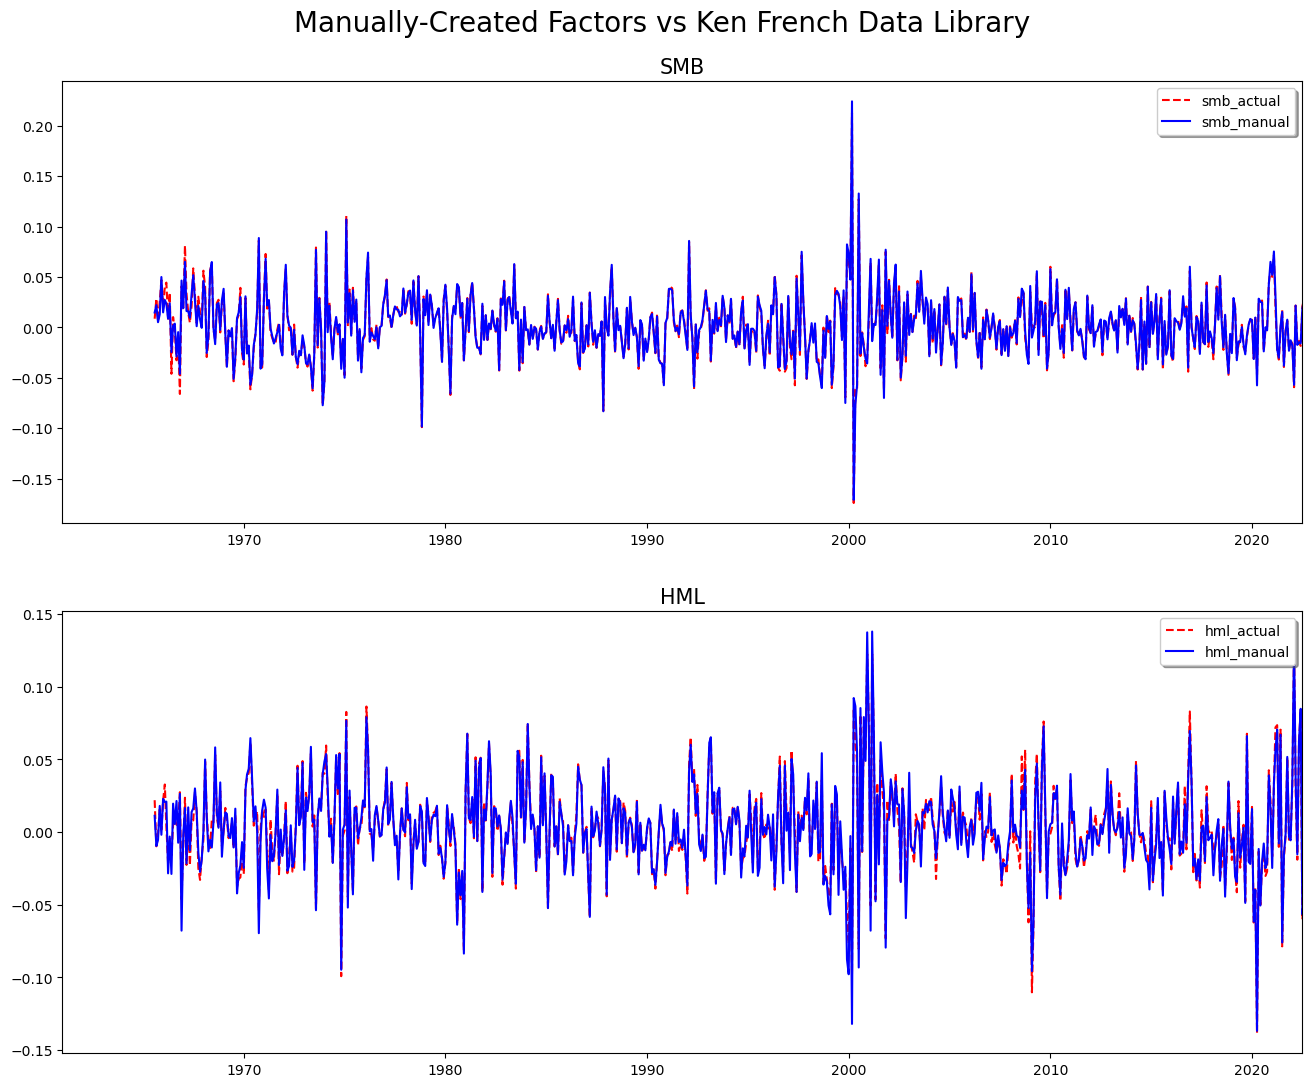

In [22]:
plt.figure(figsize=(16, 12))
plt.suptitle("Manually-Created Factors vs Ken French Data Library", fontsize=20)

ax1 = plt.subplot(211)
ax1.set_title("SMB", fontsize=15)
ax1.set_xlim([datetime.datetime(1961, 1, 1), datetime.datetime(2022, 6, 30)])
ax1.plot(ff_compare["smb_actual"], "r--", ff_compare["smb_manual"], "b-")
ax1.legend(("smb_actual", "smb_manual"), loc="upper right", shadow=True)

ax2 = plt.subplot(212)
ax2.set_title("HML", fontsize=15)
ax2.plot(ff_compare["hml_actual"], "r--", ff_compare["hml_manual"], "b-")
ax2.set_xlim([datetime.datetime(1961, 1, 1), datetime.datetime(2022, 6, 30)])
ax2.legend(("hml_actual", "hml_manual"), loc="upper right", shadow=True)

plt.subplots_adjust(top=0.92, hspace=0.2)